# CIFAR 10 Image Classification with CNN and Caffe

In this notebook, we will show how to perform image classification tasks with CNN and Caffe, and how to refine CNN performance with dropout and fine tuning pre-trained models.
- Neo Xing, 2016/10
- Modify `caffe_root`, `project_root`, `CIFAR10_DIR` based on your settings
- More information see `readme.md` and `project_report`

In [1]:
### setup env
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import caffe

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# used by some Caffe tools, command line interfaces, and workspaces
caffe_root = '/home/ubuntu/caffe/'
# used to load/store models, images, and logs
project_root = '/home/ubuntu/work/udacity-MLND/'

sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)

In [2]:
### common Caffe utilities
## data IO

# CIFAR database
cifar_model_dir = caffe_root + 'examples/cifar10/'
cifar_train_data = cifar_model_dir + 'cifar10_train_lmdb/'
cifar_test_data = cifar_model_dir + 'cifar10_test_lmdb/'

# check database
if os.path.isfile(cifar_train_data + 'data.mdb'):
    print "Cifar10 data already present..."
else:
    # Caffe codes to get cifar10
    !data/cifar10/get_cifar10.sh
    # Caffe codes to prepare cifar10
    !examples/cifar10/create_cifar10.sh


## define network
# network will be defined in prototxt

## network visualize
# python $caffe_root/python/draw_net.py input_net_proto_file output_image_file

## visualization of log file

Cifar10 data already present...


## CNN

### Using Python
- Only for demostration and visualization
- Caffe Commandline can run in batch to speed up training

In [ ]:
from caffe import layers as L, params as P
cnn_model_proto = cifar_model_dir + 'cifar10_quick.prototxt'
cnn_solver_proto = cifar_model_dir + 'cifar10_quick_solver.prototxt'

cnn = caffe.Net(cnn_model_proto, caffe.TEST)
solver = caffe.get_solver(cnn_solver_proto)

layers_shape = [(k, v.data.shape) for k, v in solver.net.blobs.items()]

params_shape = [(k, v[0].data.shape) for k, v in solver.net.params.items()]

print("Layers' features:")
for i in layers_shape:
    print i

print("Parameters and shape:")
for i in params_shape:
    print i

In [ ]:
caffe.set_mode_gpu()
#%time
#solver.solve()

In [ ]:
# the main solver loop
print "**** Entering Solver Loop ****"
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:10]
    
    # Display results once in a while
    if it % disp_interval == 0:
        print "Iteration", it, "train loss.... = ", train_loss[it]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct/1e4
        print 'Iteration', it, 
        print 'testing... test accuracy = ', 
        print test_acc[it//test_interval], '| train loss = ', train_loss[it]

In [ ]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

### Using bash

In [ ]:
## Must be executed at caffe root dir
## the model and scripts must be located in caffe_root/examples/cifar10 dir

# train full convnet
!nohup ./examples/cifar10/train_full.sh 2>&1 > ./examples/cifar10/train_full.log &

# train cnn with dropout
!nohup ./examples/cifar10/train_dropout.sh 2>&1 > ./examples/cifar10/train_dropout.log &

# train caffenet with fine-tuning
!nohup ./examples/cifar10/train_caffenet.sh 2>&1 > ./examples/cifar10/train_caffenet.log &

In [3]:
import subprocess
import pandas as pd

def plot_log(log_file, caffe_root=caffe_root):
    '''
    Return 
    '''
    log_dir = os.path.dirname(os.path.abspath(log_file))
    os.chdir(log_dir)
    command = os.path.join(caffe_root + 'tools/extra/parse_log.sh') + ' ' + log_file
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process.wait()
    
    train_csv, test_csv = log_file + '.train', log_file + '.test'
    
    # read training and test logs
    train_log, test_log = pd.read_csv(train_csv, delim_whitespace=True), pd.read_csv(test_csv, delim_whitespace=True)

    # plot
    fig, ax1 = plt.subplots()

    #Plotting training and test losses
    train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'], color='red',  alpha=.5)
    test_loss, = ax1.plot(test_log['#Iters'], test_log['TestLoss'], linewidth=2, color='green')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.set_xlabel('Iterations', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.tick_params(labelsize=15)
    #Plotting test accuracy
    ax2 = ax1.twinx()
    test_accuracy, = ax2.plot(test_log['#Iters'], test_log['TestAccuracy'], linewidth=2, color='blue')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.tick_params(labelsize=15)
    #Adding legend
    plt.legend([train_loss, test_loss, test_accuracy], ['Training Loss', 'Test Loss', 'Test Accuracy'])#,  bbox_to_anchor=(1, 0.8))
    plt.title('Training Curve', fontsize=18)
    #Saving learning curve
    #plt.savefig(learning_curve_path)
    plt.show()

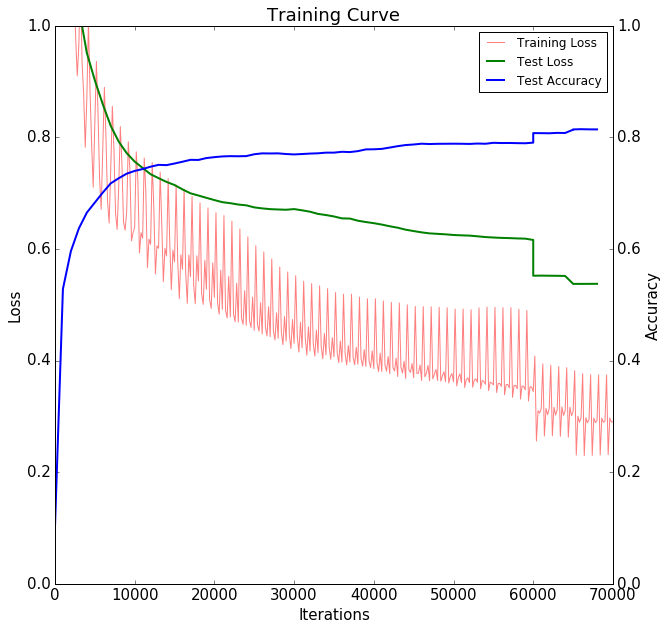

In [8]:
plot_log('/home/ubuntu/caffe/examples/cifar10/train_full.log')

### CNN with droput

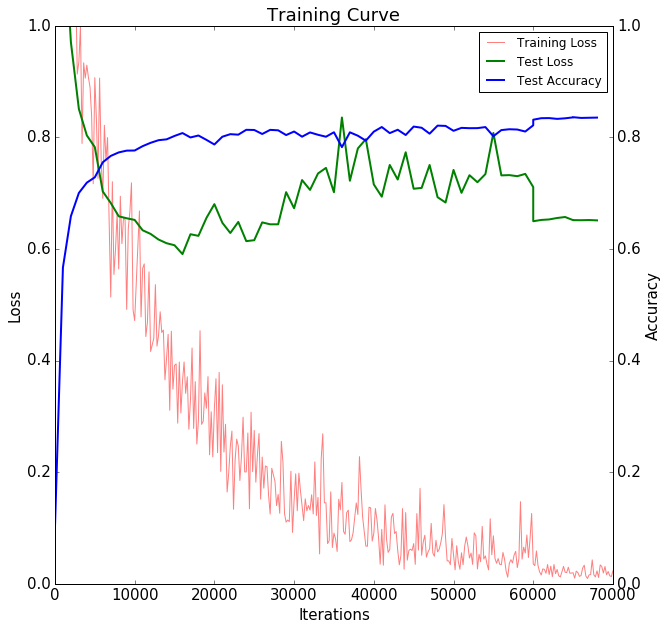

In [5]:
plot_log('/home/ubuntu/caffe/examples/cifar10/train_dropout.log')

### Fine tuning Cafeenet

In [6]:
## CIFAR utils
import os
import cPickle

# CIFAR_10 data dir
CIFAR10_DIR = '/home/ubuntu/.keras/datasets/cifar-10-batches-py'

# preprocess
def unpickle(filename):
    with open(filename, 'rb') as fo:
        data_dict = cPickle.load(fo)
    return data_dict

def load_patch(data_dir, data_file):
    data_dict = unpickle(os.path.join(data_dir, data_file))
    X, y = data_dict['data'], np.array(data_dict['labels'])
    #y = y.reshape(y.size, 1)
    return X, y

def load_CIFAR10(data_dir=CIFAR10_DIR):
    # train data
    train_data_prefix = 'data_batch_'
    nbatches = 5
    Xtr, Ytr = [], []
    for i in range(nbatches):
        train_data = load_patch(data_dir, train_data_prefix + str(i+1))
        Xtr.append(train_data[0])
        Ytr.append(train_data[1])
    Xtr = np.vstack(Xtr)
    Ytr = np.hstack(Ytr)
    #Ytr = Ytr.reshape(Ytr.size, 1)
    # test data
    test_data = load_patch(data_dir, 'test_batch')
    Xte, Yte = test_data
    # meta data
    meta_data = unpickle(os.path.join(data_dir, 'batches.meta'))
    label_names = meta_data['label_names']
    return Xtr, Ytr, Xte, Yte, label_names

In [75]:
## load data
Xtr, Ytr, Xte, Yte, label_names = load_CIFAR10(CIFAR10_DIR)
print "Xtr", Xtr.shape
print "Ytr", Ytr.shape
print "Xte", Xte.shape
print "Yte", Yte.shape
print "image", Xtr[0].shape

Xtr (50000, 3072)
Ytr (50000,)
Xte (10000, 3072)
Yte (10000,)
image (3072,)


In [67]:
from PIL import Image
import os
import glob
import random
import numpy as np
import cv2
import caffe
from caffe.proto import caffe_pb2
import lmdb

CIFAR10_WIDTH = 32
CIFAR10_HEIGHT = 32
CIFAR10_K = 3
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

def cifar_to_rgb(img_array, width=CIFAR10_WIDTH, height=CIFAR10_HEIGHT):
    return np.reshape(np.reshape(img_array, (CIFAR10_K, -1)).T, (width, height, -1))

def transform_image(img, label, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT, histogram_equalization=False):
    '''
    convert CIFAR10 (image, label) to Caffe datum in ImageNet form, performing
        resizing
        switch channel from RGB to BGR
        optional histogram equalization
    '''
    img = cifar_to_rgb(img)
    # histogram equalization
    if histogram_equalization:
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
        img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    # image resizing
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    # convert rgb to bgr
    img = np.rollaxis(img, 2, 0)
    # pack into Caffe datum
    datum = caffe_pb2.Datum(channels=3,
                            width=img_width,
                            height=img_height,
                            label=label,
                            data=img.tostring())
    return datum
    
def create_lmdb(images, labels, lmdb_path):
    '''
    create leveldb from CIFAR images and labels
    '''
    in_db = lmdb.open(lmdb_path, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        for i, img in enumerate(images):
            label = labels[i]
            datum = transform_image(img, label)
            in_txn.put('{:0>5d}'.format(i), datum.SerializeToString())
            if i % 1000 == 0:
                print i
    in_db.close()

In [68]:
## create leveldb of CIFAR 10 images in ImageNet image format
CIFAR10_caffenet_train_lmdb = cifar_model_dir + 'cifar10_caffenet_train_lmdb'
CIFAR10_caffenet_test_lmdb = cifar_model_dir + 'cifar10_caffenet_test_lmdb'

Xtr, Ytr, Xte, Yte, label_names = load_CIFAR10(CIFAR10_DIR)
# 10000 ~ 2GB data, 10 times to 50000 original
N_TRAIN = 10000
N_TEST = 2000

## create leveldb
if not os.path.isdir(CIFAR10_caffenet_train_lmdb):
    print "Load and create database", CIFAR10_caffenet_train_lmdb
    create_lmdb(Xtr[:N_TRAIN], Ytr[:N_TRAIN], CIFAR10_caffenet_train_lmdb)
    #create_lmdb(Xtr, Ytr, CIFAR10_caffenet_train_lmdb)
    print "Done, total items", N_TRAIN
    
if not os.path.isdir(CIFAR10_caffenet_test_lmdb):
    print "Load and create database", CIFAR10_caffenet_test_lmdb
    create_lmdb(Xte[:N_TEST], Yte[:N_TEST], CIFAR10_caffenet_test_lmdb)
    #create_lmdb(Xte, Yte, CIFAR10_caffenet_test_lmdb)
    print "Done, total items", N_TEST

## check leveldb
with lmdb.open(CIFAR10_caffenet_train_lmdb) as db:
    with db.begin(write=True) as txn:
        n = db.stat()['entries']
        assert n == N_TRAIN

with lmdb.open(CIFAR10_caffenet_test_lmdb) as db:
    with db.begin(write=True) as txn:
        n = db.stat()['entries']
        assert n == N_TEST
        

## generate mean image of training data
cifar_caffenet_mean = cifar_model_dir + 'cifar10_caffenet_mean.binaryproto'
if not os.path.isfile(cifar_caffenet_mean):
    print "Create mean image", cifar_caffenet_mean
    print "of training data", CIFAR10_caffenet_train_lmdb
    os.chdir(cifar_model_dir)
    command = os.path.join(caffe_root + 'build/tools/compute_image_mean') + ' ' +\
              '-backend=lmdb' + ' ' +\
              CIFAR10_caffenet_train_lmdb + ' ' +\
              cifar_caffenet_mean
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process.wait()
    print "Done"

Load and create database /home/ubuntu/caffe/examples/cifar10/cifar10_caffenet_train_lmdb
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Done, total items 10000
Load and create database /home/ubuntu/caffe/examples/cifar10/cifar10_caffenet_test_lmdb
0
1000
Done, total items 2000
Create mean image /home/ubuntu/caffe/examples/cifar10/cifar10_caffenet_mean.binaryproto
of training data /home/ubuntu/caffe/examples/cifar10/cifar10_caffenet_train_lmdb
Done


In [90]:
def caffe_img_to_rgb(img_array):
    '''
    convert caffe img blob to rgb array
    '''
    b, g, r = img_array
    k, w, h = img_array.shape
    img = np.zeros((w, h, k), dtype='uint8')
    for i in range(w):
        for j in range(h):
            img[i, j, :] = np.array([r[i, j], g[i,j], b[i, j]])
    return img
def caffe_img_to_rgb(img_array):
    return np.rollaxis(img_array, 0, 3)

def lmdb_entry(database, k):
    with lmdb.open(database) as db:
        with db.begin(write=False) as txn:
            entry = txn.get('{:0>5d}'.format(k))
    return entry

def datum_to_array(data):
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(data)
    img = caffe.io.datum_to_array(datum)
    return img

def lmdb_image(database, label):
    img_datum = lmdb_entry(database, label)
    img_array = datum_to_array(img_datum)
    img_rgb = caffe_img_to_rgb(img_array)
    return img_rgb

def caffe_binaryproto_img(filename):
    '''
    load mean binaryproto file to rgb image array
    '''
    mean_img_data = open(filename, 'rb' ).read()
    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(mean_img_data)
    mean_img_array = np.array(caffe.io.blobproto_to_array(blob))[0]
    mean_img = caffe_img_to_rgb(mean_img_array)
    return mean_img.astype(np.uint8)

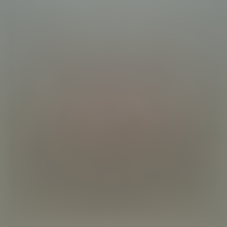

In [92]:
## show mean image
caffe_mean_img_rgb = caffe_binaryproto_img(cifar_caffenet_mean)
caffe_mean_img = Image.fromarray(caffe_mean_img_rgb)
display(caffe_mean_img)

In [87]:
def cifar_img(img_array, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):
    '''
    resize and convert CIFAR10 to rgb image array
    '''
    img = cifar_to_rgb(img_array)
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    return img

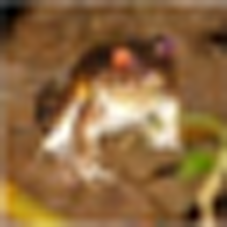

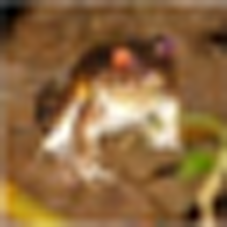

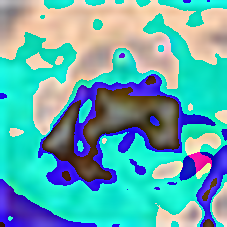

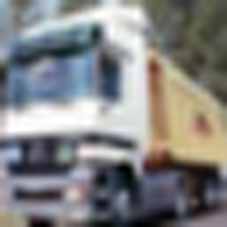

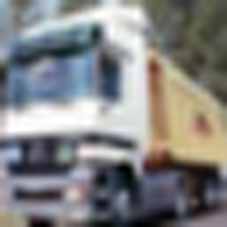

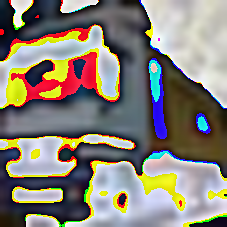

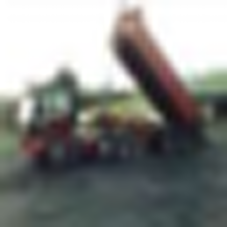

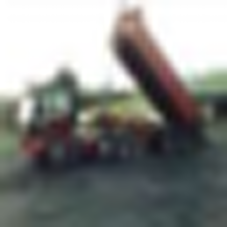

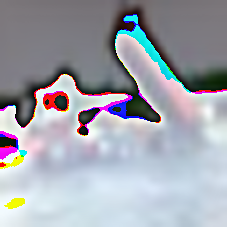

In [93]:
## show orginal, retrived from database, and centered image samples
for i in range(3):
    display(Image.fromarray(cifar_img(Xtr[i])))
    img = lmdb_image(CIFAR10_caffenet_train_lmdb, i)
    display(Image.fromarray(img))
    display(Image.fromarray(img-caffe_mean_img))

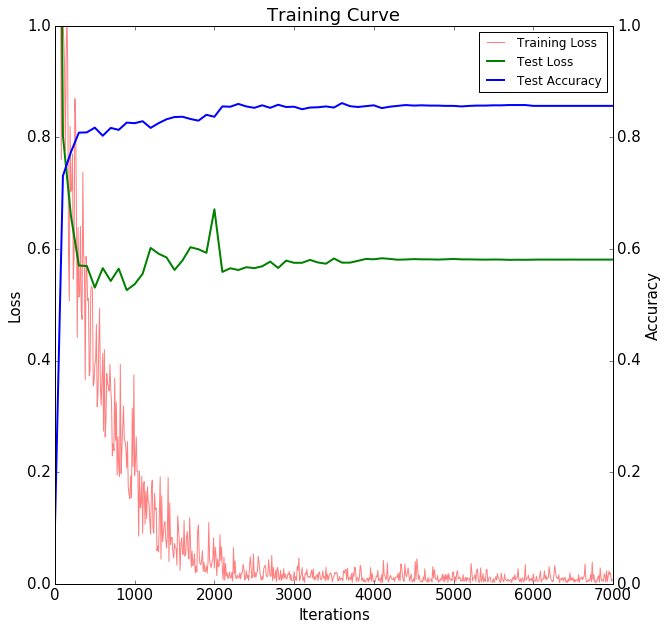

In [6]:
plot_log('/home/ubuntu/caffe/examples/cifar10/train_caffenet_histo_eq.log')

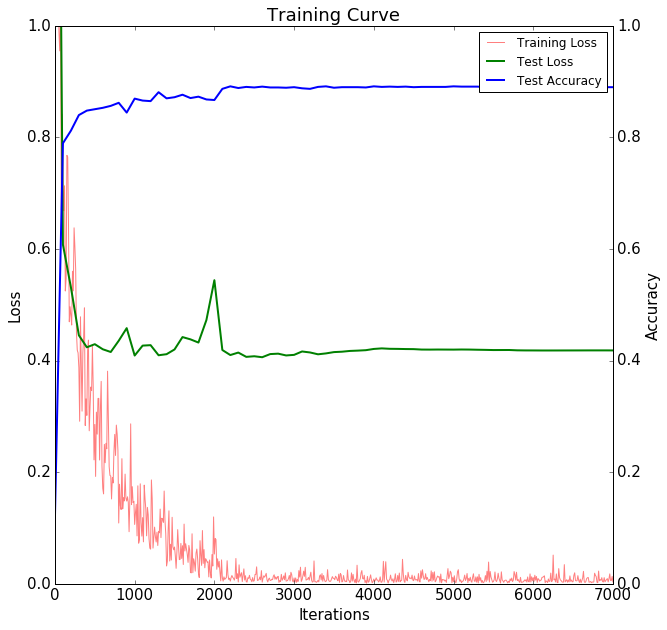

In [7]:
plot_log('/home/ubuntu/caffe/examples/cifar10/train_caffenet.log')

In [6]:
from google.protobuf import text_format
import caffe
import caffe.draw
from caffe.proto import caffe_pb2

## generate net structure
def draw_caffe_net(net_proto_file, net_image_file=''):
    if not net_image_file:
        net_image_file = os.path.splitext(net_proto_file)[0] + '.png'
    net = caffe_pb2.NetParameter()
    text_format.Merge(open(net_proto_file).read(), net)
    caffe.draw.draw_net_to_file(net, net_image_file, rankdir='LR')
    net_img = Image.open(net_image_file)
    return net_img

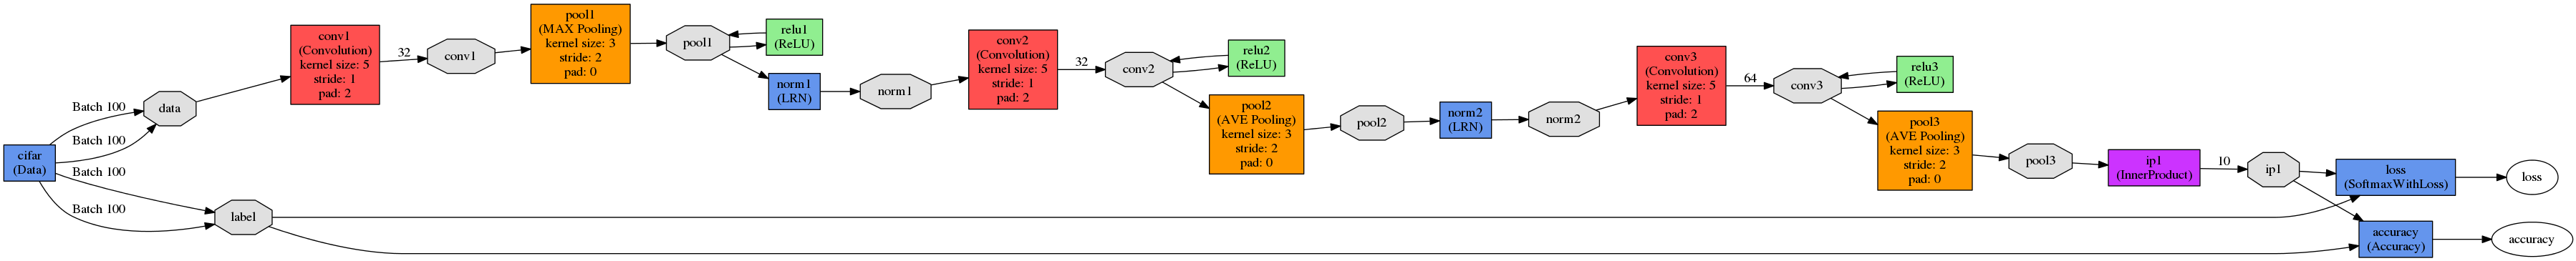

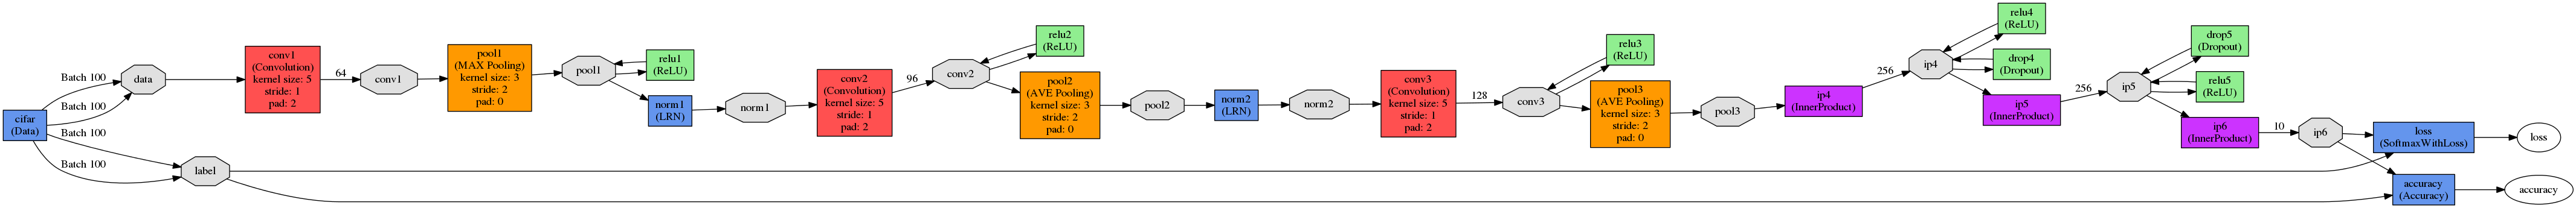

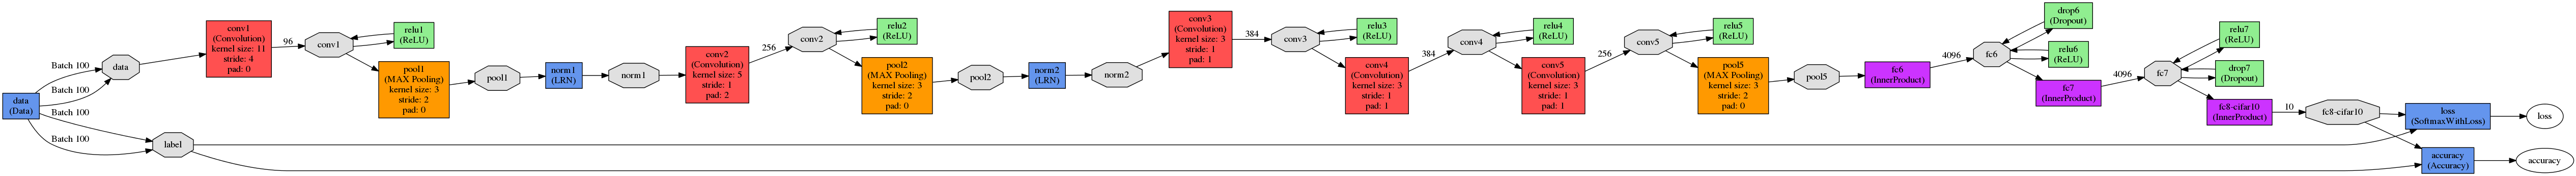

In [7]:
cifar10_cnn_proto = cifar_model_dir + 'cifar10_full_train_test.prototxt'
cifar10_dropout_proto = cifar_model_dir + 'cifar10_dropout_train_test.prototxt'
cifar10_caffenet_proto = cifar_model_dir + 'cifar10_caffenet_train_test.prototxt'

for net_proto_file in (cifar10_cnn_proto, cifar10_dropout_proto, cifar10_caffenet_proto):
    display(draw_caffe_net(net_proto_file))